In [1]:
%config InlineBackend.figure_formats = ['svg']

import pandas as pd
import numpy as np
from os.path import join, dirname
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import itertools
import pickle
%matplotlib inline
import admix
from admix import chi2_to_logpval
from scipy.stats import ttest_ind
import scipy
from IPython.display import display, Markdown, Latex

In [2]:
geno_sim_prefix = "EUR_0.2_AFR_0.8_7_10000"
# geno_sim_prefix = "EUR_0.5_AFR_0.5_10_10000"
data_dir = f"out/single_snp_test/{geno_sim_prefix}"
geno_data_dir = f"data/geno/{geno_sim_prefix}/"

In [3]:
anc = np.load(join(geno_data_dir, "anc.npy"))
phgeno = np.load(join(geno_data_dir, "phgeno.npy"))
legend = pd.read_csv(join(geno_data_dir, "legend.csv"))
subset_index = np.arange(0, anc.shape[1], 30)

anc = anc[:, subset_index]
phgeno = phgeno[:, subset_index]
legend = legend.loc[subset_index, :]
n_indiv = anc.shape[0] // 2
n_snp = anc.shape[1]
anc = anc.reshape(n_indiv, n_snp * 2)
phgeno = phgeno.reshape((n_indiv, n_snp * 2))
geno = admix.convert_anc_count(anc=anc, phgeno=phgeno)

# Plotting the allele frequency

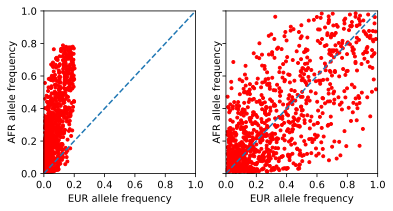

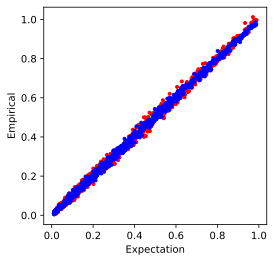

In [4]:
fig, axs = plt.subplots(figsize=(6, 3), ncols=2, sharex=True, sharey=True)
allele_freq = geno.mean(axis=0) / 2
eur_allele_freq = allele_freq[0 : n_snp]
afr_allele_freq = allele_freq[n_snp : (2 * n_snp)]
axs[0].plot(eur_allele_freq, afr_allele_freq , 'r.')
axs[1].plot(legend.EUR.values, legend.AFR.values, 'r.')

for ax_i in range(2):
    axs[ax_i].plot([0, 1], [0,1], '--')
    axs[ax_i].set_xlim(0, 1)
    axs[ax_i].set_ylim(0, 1)
    axs[ax_i].set_xlabel("EUR allele frequency")
    axs[ax_i].set_ylabel("AFR allele frequency")
plt.figure(figsize=(4, 4))
plt.plot(legend.EUR.values, eur_allele_freq / 0.2, 'r.')
plt.plot(legend.AFR.values, afr_allele_freq / 0.8, 'b.')
plt.xlabel("Expectation")
plt.ylabel("Empirical")
plt.show()

In [5]:
score_df_dict = dict()
var_g_list = [0.05, 0.075, 0.1, 0.2]
cov_list = [0.8, 1.0]
param_list = [param for param in itertools.product(var_g_list, cov_list)]
param_list.append((0.0, 0.0))

for var_g, cov in param_list:
    score_df_dict[(var_g, cov)] = pd.read_csv(join(data_dir, f"{var_g}_{cov}", "summary.csv"))

# Null simulation

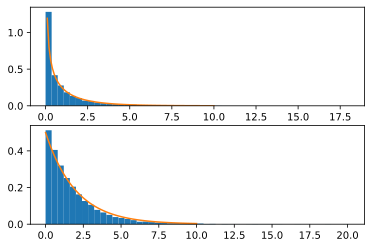

ADM        0.028270
ATT        0.050049
MIX        0.048374
SNP1       0.046279
SUM        0.033575
TRACTOR    0.052492
dtype: float64


In [12]:
score_df = score_df_dict[(0.0, 0.0)].copy().dropna()
score_df = score_df[score_df.SNP_I.isin(diff_snps)]
pval_df = score_df.iloc[:, 0:6].copy()

pval_df.iloc[:, 0:4] = stats.chi2.sf(pval_df.iloc[:, 0:4], df=1)
pval_df.loc[:, "SUM"] = stats.chi2.sf(pval_df.loc[:, "SUM"], df=2)

fig, axs = plt.subplots(nrows=2)
axs[0].hist(score_df.MIX, bins=50, density=True)
x_grid = np.linspace(0, 10, 100)
axs[0].plot(x_grid, stats.chi2.pdf(x_grid, df=1))
axs[1].hist(score_df.SUM, bins=50, density=True)
axs[1].plot(x_grid, stats.chi2.pdf(x_grid, df=2))
plt.show()
# qq_fig, qq_axs = plt.subplots(1, pval_df.shape[1], figsize=(15,3))
# for col_i, col in enumerate(pval_df.columns):
#     zsc = admix.pval2zsc(pval_df[col].values)
#     sm.qqplot(zsc, line="45", ax=qq_axs[col_i])
#     qq_axs[col_i].set_title(col)
# plt.tight_layout()

print(np.mean(pval_df.iloc[:, 0:6] < 0.05, axis=0))

# Power in alternative simulation

In [10]:
diff_snps = np.where(np.abs(legend.EUR.values - legend.AFR.values) > 0.2)[0]
only_diff_snp = True
df = {"cov": [], "score": [], "var_g": [], "sig_prop": []}
for cov_i, cov in enumerate(cov_list):
    for var_g in var_g_list:
        pval_df = score_df_dict[(var_g, cov)].copy().dropna()
        if only_diff_snp:
            pval_df = pval_df[pval_df.SNP_I.isin(diff_snps)]
        pval_df.iloc[:, 0:4] = stats.chi2.sf(pval_df.iloc[:, 0:4], df=1)
        pval_df.loc[:, "SUM"] = stats.chi2.sf(pval_df.loc[:, "SUM"], df=2)
        for score in pval_df.columns[0:6]:
            df["cov"].append(cov)
            df["score"].append(score)
            df["var_g"].append(var_g)
            p_threshold = 1e-5 if score == "ADM" else 5e-8
            sig_prop = pval_df.groupby("SIM_I").apply(lambda x: np.mean(x[score] < p_threshold))
            sig_prop_mean = np.mean(sig_prop)
            sig_prop_se = np.std(sig_prop) / np.sqrt(len(sig_prop))
            df["sig_prop"].append(sig_prop_mean)
#             df["sig_prop"].append(f"{np.mean(sig_prop):.3f}({sig_prop_se * 2:.3f})")
df = pd.DataFrame(df)
file_name = f"{geno_sim_prefix}.only_diff" if only_diff_snp else f"{geno_sim_prefix}" 
df.pivot(index=["cov", "var_g"], columns='score').to_excel(f"manuscript/{file_name}.xlsx")

# Deprecated

In [13]:
# fig, axs = plt.subplots(nrows=len(cov_list), figsize=(5, 18))
df = {"cov": [], "score": [], "var_g": [], "sig_prop": []}
for cov_i, cov in enumerate(cov_list):
    for var_g in var_g_list:
        pval_df = score_df_dict[(var_g, cov)].copy().dropna()
#         pval_df = pval_df[pval_df.SNP_I.isin(diff_snps)]
        pval_df.iloc[:, 0:4] = stats.chi2.sf(pval_df.iloc[:, 0:4], df=1)
        pval_df.loc[:, "SUM"] = stats.chi2.sf(pval_df.loc[:, "SUM"], df=2)
        for score in pval_df.columns[0:6]:
            df["cov"].append(cov)
            df["score"].append(score)
            df["var_g"].append(var_g)
            p_threshold = 1e-5 if score == "ADM" else 5e-8
            sig_prop = pval_df.groupby("SIM_I").apply(lambda x: np.mean(x[score] < p_threshold))
            sig_prop_mean = np.mean(sig_prop)
            sig_prop_se = np.std(sig_prop) / np.sqrt(len(sig_prop))
#             df["sig_prop"].append(sig_prop_mean)
            df["sig_prop"].append(f"{np.mean(sig_prop):.3f}({sig_prop_se * 2:.3f})")
df = pd.DataFrame(df)

# df.pivot(index=["cov", "var_g"], columns='score').to_excel(f"manuscript/{geno_sim_prefix}.xlsx")


sig_prop                                            \
score               ADM           ATT           MIX          SNP1   
cov var_g                                                           
0.8 0.050  0.024(0.001)  0.182(0.003)  0.192(0.003)  0.174(0.003)   
    0.075  0.058(0.002)  0.463(0.005)  0.474(0.005)  0.449(0.005)   
    0.100  0.092(0.002)  0.656(0.005)  0.661(0.004)  0.644(0.005)   
    0.200  0.198(0.003)  0.840(0.003)  0.837(0.003)  0.838(0.003)   
1.0 0.050  0.001(0.000)  0.299(0.004)  0.312(0.004)  0.283(0.004)   
    0.075  0.003(0.001)  0.693(0.004)  0.706(0.004)  0.673(0.005)   
    0.100  0.006(0.001)  0.900(0.003)  0.900(0.003)  0.888(0.003)   
    0.200  0.039(0.001)  0.996(0.001)  0.989(0.001)  0.997(0.000)   

                                       
score               SUM       TRACTOR  
cov var_g                              
0.8 0.050  0.153(0.003)  0.168(0.003)  
    0.075  0.461(0.005)  0.481(0.005)  
    0.100  0.702(0.005)  0.722(0.005)  
    0.200  0.921(0.002)  0.949(0.002)  
1.0 0.050  0.226(0.003)  0.208(0.003)  
    0.075  0.618(0.005)  0.579(0.004)  
    0.100  0.862(0.003)  0.833(0.003)  
    0.200  0.996(0.001)  0.995(0.001)

var_g = 0.005, cov = 0.8
SUM - TRACTOR:  Ttest_indResult(statistic=-4.312472537294807, pvalue=1.629879816606969e-05)
MIX - TRACTOR:  Ttest_indResult(statistic=3.265789067792321, pvalue=0.0010953440722408924)
MIX - SUM:  Ttest_indResult(statistic=7.454589687123765, pvalue=9.777944636761383e-14)
   ADM  ATT  MIX  SNP1  SUM  TRACTOR
0  0.0  0.0  0.0   0.0  0.0      0.0
-----
var_g = 0.005, cov = 1.0
SUM - TRACTOR:  Ttest_indResult(statistic=-2.234988209717158, pvalue=0.025440122036325022)
MIX - TRACTOR:  Ttest_indResult(statistic=10.16877889560698, pvalue=3.601762842753276e-24)
MIX - SUM:  Ttest_indResult(statistic=12.383651221373004, pvalue=5.845866219829111e-35)
   ADM  ATT  MIX  SNP1  SUM  TRACTOR
0  0.0  0.0  0.0   0.0  0.0      0.0
-----
var_g = 0.01, cov = 0.8
SUM - TRACTOR:  Ttest_indResult(statistic=-4.063451669485032, pvalue=4.8722098678252986e-05)
MIX - TRACTOR:  Ttest_indResult(statistic=3.5692981568217594, pvalue=0.00035965035014949646)
MIX - SUM:  Ttest_indResult(statistic=7.

/u/local/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


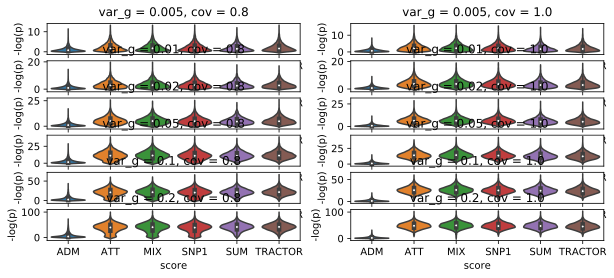

In [27]:
var_g_list = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
fig, axs = plt.subplots(nrows=len(var_g_list), ncols=2, figsize=(10, 4))
for row_i, var_g in enumerate(var_g_list):
    for col_i, cov in enumerate([0.8, 1.0]):
        score_df = score_df_dict[(var_g, cov)].copy()
        score_df.iloc[:, 0:4] = -chi2_to_logpval(score_df.iloc[:, 0:4], dof=1)
        score_df.loc[:, "SUM"] = -chi2_to_logpval(score_df.loc[:, "SUM"], dof=2)
        score_df.loc[:, "TRACTOR"] = -np.log(score_df.loc[:, "TRACTOR"])
        melted = score_df.iloc[:, 0:6].melt(var_name="score", value_name="-log(p)")
        sns.violinplot(x="score", y="-log(p)", data=melted, ax=axs[(row_i, col_i)], scale="width")
        axs[(row_i, col_i)].set_title(f'var_g = {var_g}, cov = {cov}', y=1.05)
        print(f"var_g = {var_g}, cov = {cov}")
        print("SUM - TRACTOR: ", ttest_ind(score_df.SUM, score_df.TRACTOR, nan_policy="omit"))
        print("MIX - TRACTOR: ", ttest_ind(score_df.MIX, score_df.TRACTOR, nan_policy="omit"))
        print("MIX - SUM: ", ttest_ind(score_df.MIX, score_df.SUM, nan_policy="omit"))
        print(pd.DataFrame(np.mean(score_df.iloc[:, 0:6] > -np.log(5e-8), axis=0)).T)
        print('-----')
plt.tight_layout()
plt.show()

In [ ]:
#     sns.lineplot(data=df, x="var_g", y="sig_prop", hue="score", marker="o", ax=axs[cov_i])
#     axs[cov_i].set_title(f"Cov: {cov}")
#     axs[cov_i].set_xlabel("Variance of genetic component")
#     axs[cov_i].set_ylabel(f"Proportion of SNPs with p < {pval_threshold}")
#     display(Markdown(f"## Cov: {cov}"))
#     display(df.pivot(index='var_g', columns='score').iloc[:, 1:])
# plt.tight_layout()
# plt.show()